In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

In [2]:
filename = "../ML model/data_delT.csv"
df = pd.read_csv(filename, header=0, sep=',', dtype=np.float64)
print('Are ther any Nan value?:\n', np.isnan(df).any())
# ignore rows which contain zero
# ignore rows which have negative instantaneous rate
ignore_zero = df[(df['Strain']==0) | (df['Stress']==0) | (df['Temp']==0) | (df['Rate']<=0) | (df['I_Temp']==0)]
df=pd.concat([df, ignore_zero, ignore_zero]).drop_duplicates(keep=False)
df=pd.concat([df, ignore_zero, ignore_zero]).drop_duplicates(keep=False)
df.head()

Are ther any Nan value?:
 Strain    False
Stress    False
delT      False
Rate      False
I_Temp    False
Temp      False
dtype: bool


,Strain,Stress,delT,Rate,I_Temp,Temp
0,0.0004,230.616121,0.0,0.000278,293.0,293.0
1,0.0005,233.817714,0.0,0.000278,293.0,293.0
2,0.0006,236.126706,0.0,0.000278,293.0,293.0
3,0.0007,237.659430,0.0,0.000278,293.0,293.0
4,0.0008,239.052686,0.0,0.000278,293.0,293.0


## Splitting flow curves

In [3]:
# Flow curve in normal environment; room temperature/quasi-static loading
df_QSRT = df[(df['Temp']==293.0) & (df['Rate']==0.000278)]
df_QSRT.head()

,Strain,Stress,delT,Rate,I_Temp,Temp
0,0.0004,230.616121,0.0,0.000278,293.0,293.0
1,0.0005,233.817714,0.0,0.000278,293.0,293.0
2,0.0006,236.126706,0.0,0.000278,293.0,293.0
3,0.0007,237.659430,0.0,0.000278,293.0,293.0
4,0.0008,239.052686,0.0,0.000278,293.0,293.0


In [7]:
# Flow curve in different temperatures
df_QSRT = df[(df['Temp']==293.0) & (df['Rate']==0.000278)]
df_373K = df[(df['Temp']==373.0) & (df['Rate']==0.000278)]
df_473K = df[(df['Temp']==473.0) & (df['Rate']==0.000278)]
df_573K = df[(df['Temp']==573.0) & (df['Rate']==0.000278)]
df_673K = df[(df['Temp']==673.0) & (df['Rate']==0.000278)]

In [8]:
# Flow curves in different strain rates, adiabatic condition
df_e4 = df[(df['Rate']==0.0001) & (df['I_Temp']==293.0)]
df_QSRT = df[(df['Rate']==0.000278) & (df['Temp']==293.0)]
df_e3 = df[(df['Rate']==0.001) & (df['I_Temp']==293.0)]
df_e2 = df[(df['Rate']==0.01) & (df['Temp']!=293.0) & (df['Temp']!=373.001) & (df['Temp']!=373.0) & (df['I_Temp']==293)]
df_e1 = df[(df['Rate']==0.1) & (df['Temp']!=293.0) & (df['I_Temp']==293)]

In [9]:
# Flow curve in isothermal conditions
df_e3_iso = df[(df['Rate']==0.001) & (df['Temp']==293.0) & (df['Strain']>=0.002)]
df_e2_iso = df[(df['Rate']==0.01) & (df['Temp']==293.0) & (df['Strain']>=0.002)]
df_e1_iso = df[(df['Rate']==0.1) & (df['Temp']==293.0) & (df['Strain']>=0.002)]
df_e2_373K_iso = df[(df['Rate']==0.01) & (df['Temp']==373.0)]
# Flow curve in isothermal conditions
df_e2_373K = df[(df['Rate']==0.01) & (df['Temp']==373.001)]

In [10]:
# Flow curves in 0.01 strain rate, adiabatic condition
df_e2_RT = df[(df['Rate']==0.01) & (df['I_Temp']==293.0)]
df_e2_373K = df[(df['Rate']==0.01) & (df['I_Temp']==373.0)]
df_e2_473K = df[(df['Rate']==0.01) & (df['I_Temp']==473.0)]
df_e2_573K = df[(df['Rate']==0.01) & (df['I_Temp']==573.0)]
df_e2_673K = df[(df['Rate']==0.01) & (df['I_Temp']==673.0)]

In [11]:
# Flow curves in 0.1 strain rate, adiabatic condition
df_e1_RT = df[(df['Rate']==0.1) & (df['I_Temp']==293.0)]
df_e1_373K = df[(df['Rate']==0.1) & (df['I_Temp']==373.0)]
df_e1_473K = df[(df['Rate']==0.1) & (df['I_Temp']==473.0)]
df_e1_573K = df[(df['Rate']==0.1) & (df['I_Temp']==573.0)]
df_e1_673K = df[(df['Rate']==0.1) & (df['I_Temp']==673.0)]

In [12]:
# Flow curves in 0.001 strain rate, adiabatic condition
df_e3_RT = df[(df['Rate']==0.001) & (df['I_Temp']==293.0)]
df_e3_373K = df[(df['Rate']==0.001) & (df['I_Temp']==373.0)]
df_e3_473K = df[(df['Rate']==0.001) & (df['I_Temp']==473.0)]
df_e3_573K = df[(df['Rate']==0.001) & (df['I_Temp']==573.0)]
df_e3_673K = df[(df['Rate']==0.001) & (df['I_Temp']==673.0)]

In [13]:
# Flow curves in 0.0001 strain rate, adiabatic condition
df_e4_RT = df[(df['Rate']==0.0001) & (df['I_Temp']==293.0)]
df_e4_373K = df[(df['Rate']==0.0001) & (df['I_Temp']==373.0)]
df_e4_473K = df[(df['Rate']==0.0001) & (df['I_Temp']==473.0)]
df_e4_573K = df[(df['Rate']==0.0001) & (df['I_Temp']==573.0)]
df_e4_673K = df[(df['Rate']==0.0001) & (df['I_Temp']==673.0)]

In [14]:
# Put all flow curves as list
flows = {'e4': df_e4,
         'e4_373K': df_e4_373K,
         'e4_473K': df_e4_473K,
         'e4_573K': df_e4_573K,
         'e4_673K': df_e4_673K,
         'QSRT': df_QSRT,
         '373K': df_373K, 
         '473K': df_473K,
         '573K': df_573K,
         '673K': df_673K,
         'e3': df_e3,
         'e3_373K': df_e3_373K,
         'e3_473K': df_e3_473K,
         'e3_573K': df_e3_573K,
         'e3_673K': df_e3_673K,
         'e2': df_e2,
         'e2_373K': df_e2_373K,
         'e2_473K': df_e2_473K,
         'e2_573K': df_e2_573K,
         'e2_673K': df_e2_673K,
         'e1': df_e1,
         'e1_373K': df_e1_373K,
         'e1_473K': df_e1_473K,
         'e1_573K': df_e1_573K,
         'e1_673K': df_e1_673K
        }

In [15]:
beta_flows = {'e4': df_e4, 'QSRT': df_QSRT, 'e3': df_e3, 'e2': df_e2, 'e1': df_e1}
beta_flows1 = {'e4_373K': df_e4_373K, '373K': df_373K, 'e3_373K': df_e3_373K, 'e2_373K': df_e2_373K, 'e1_373K': df_e1_373K}
beta_flows2 = {'e4_473K': df_e4_473K, '473K': df_473K, 'e3_473K': df_e3_473K, 'e2_473K': df_e2_473K, 'e1_473K': df_e1_473K}
beta_flows3 = {'e4_573K': df_e4_573K, '573K': df_573K, 'e3_573K': df_e3_573K, 'e2_573K': df_e2_573K, 'e1_573K': df_e1_573K}
beta_flows4 = {'e4_673K': df_e4_673K, '673K': df_673K, 'e3_673K': df_e3_673K, 'e2_673K': df_e2_673K, 'e1_673K': df_e1_673K}

## Plot all the flow curves

(100.0, 550.0)

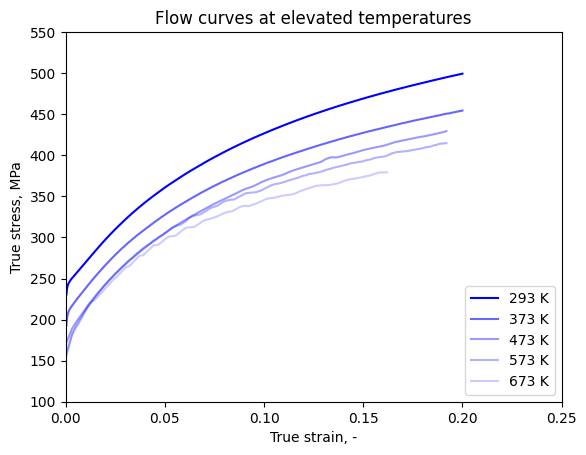

In [16]:
# QSRT

plt.plot(df_QSRT['Strain'], df_QSRT['Stress'], label='293 K', color='blue', alpha=1.0)
plt.plot(df_373K['Strain'], df_373K['Stress'], label='373 K', color='blue', alpha=0.6)
plt.plot(df_473K['Strain'], df_473K['Stress'], label='473 K', color='blue', alpha=0.4)
plt.plot(df_573K['Strain'], df_573K['Stress'], label='573 K', color='blue', alpha=0.3)
plt.plot(df_673K['Strain'], df_673K['Stress'], label='673 K', color='blue', alpha=0.2)

plt.xlabel('True strain, -')    #Name x label
plt.ylabel('True stress, MPa')    #Name y label
plt.title('Flow curves at elevated temperatures')    #Title name
plt.legend(loc=4)
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=100, ymax=550) # y-axis range

(100.0, 550.0)

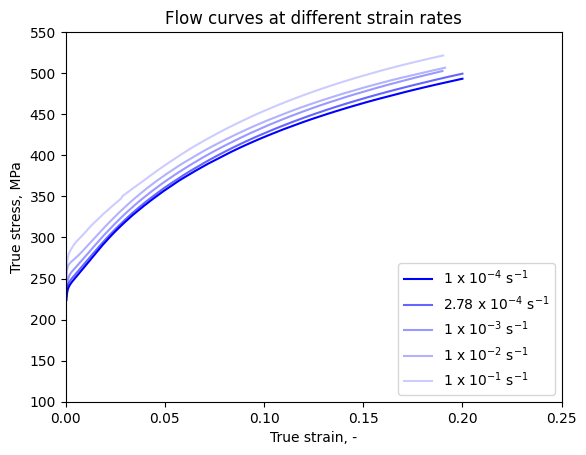

In [17]:
# Different strain rates

plt.plot(df_e4_RT['Strain'], df_e4_RT['Stress'], label='1 x 10$^{-4}$ s$^{-1}$', color='blue', alpha=1.0)
plt.plot(df_QSRT['Strain'], df_QSRT['Stress'], label='2.78 x 10$^{-4}$ s$^{-1}$', color='blue', alpha=0.6)
plt.plot(df_e3_RT['Strain'], df_e3_RT['Stress'], label='1 x 10$^{-3}$ s$^{-1}$', color='blue', alpha=0.4)
plt.plot(df_e2_RT['Strain'], df_e2_RT['Stress'], label='1 x 10$^{-2}$ s$^{-1}$', color='blue', alpha=0.3)
plt.plot(df_e1_RT['Strain'], df_e1_RT['Stress'], label='1 x 10$^{-1}$ s$^{-1}$', color='blue', alpha=0.2)

plt.xlabel('True strain, -')    #Name x label
plt.ylabel('True stress, MPa')    #Name y label
plt.title('Flow curves at different strain rates')    #Title name
plt.legend(loc=4)
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=100, ymax=550) # y-axis range

(100.0, 550.0)

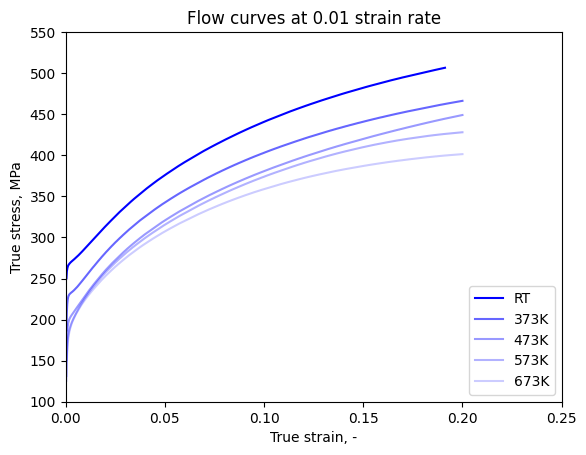

In [18]:
# 0.01 strain rate, all temperatures

plt.plot(df_e2_RT['Strain'], df_e2_RT['Stress'], label='RT', color='blue', alpha=1.0)
plt.plot(df_e2_373K['Strain'], df_e2_373K['Stress'], label='373K', color='blue', alpha=0.6)
plt.plot(df_e2_473K['Strain'], df_e2_473K['Stress'], label='473K', color='blue', alpha=0.4)
plt.plot(df_e2_573K['Strain'], df_e2_573K['Stress'], label='573K', color='blue', alpha=0.3)
plt.plot(df_e2_673K['Strain'], df_e2_673K['Stress'], label='673K', color='blue', alpha=0.2)

plt.xlabel('True strain, -')    #Name x label
plt.ylabel('True stress, MPa')    #Name y label
plt.title('Flow curves at 0.01 strain rate')    #Title name
plt.legend(loc=4)
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=100, ymax=550) # y-axis range

(100.0, 550.0)

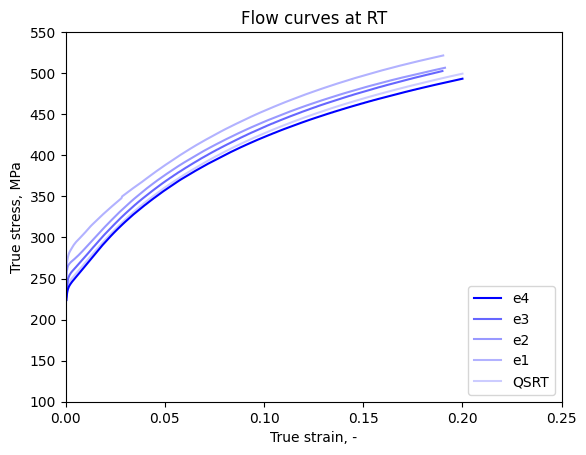

In [19]:
# RT all strain rates

plt.plot(df_e4_RT['Strain'], df_e4_RT['Stress'], label='e4', color='blue', alpha=1.0)
plt.plot(df_e3_RT['Strain'], df_e3_RT['Stress'], label='e3', color='blue', alpha=0.6)
plt.plot(df_e2_RT['Strain'], df_e2_RT['Stress'], label='e2', color='blue', alpha=0.4)
plt.plot(df_e1_RT['Strain'], df_e1_RT['Stress'], label='e1', color='blue', alpha=0.3)
plt.plot(df_QSRT['Strain'], df_QSRT['Stress'], label='QSRT', color='blue', alpha=0.2)

plt.xlabel('True strain, -')    #Name x label
plt.ylabel('True stress, MPa')    #Name y label
plt.title('Flow curves at RT')    #Title name
plt.legend(loc=4)
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=100, ymax=550) # y-axis range

## Preprocessing

In [20]:
# apply decadic log
flows_log = {}
for key, fc in flows.items():
    fc = fc.reset_index(drop=True)
    # apply decadic log to strain rates
    log_rate = pd.DataFrame(np.log10(fc['Rate'].values))
    log_rate.columns = ['log_rate']
    # apply decadic log to strain
    log_strain = pd.DataFrame(np.log10(fc['Strain'].values))
    log_strain.columns = ['log_strain']
    
    fc_log = pd.concat([fc, log_strain, log_rate], axis=1)
    fc_log = fc_log.drop(columns=['Strain', 'Rate'])
    cols = ['log_strain', 'log_rate', 'I_Temp', 'Temp', 'Stress', 'delT']
    fc_log = fc_log[cols]
    flows_log[key] = fc_log
raw_features = len(flows_log['QSRT'].columns.values)
flows_log['QSRT'].columns.values

array(['log_strain', 'log_rate', 'I_Temp', 'Temp', 'Stress', 'delT'],
      dtype=object)

In [5]:
import numpy as np
print([np.log10(0.25), np.log10(1e-9)])
print([np.log10(0.1), np.log10(0.0001)])
print((np.log10(0.1) - np.log10(0.25))/np.log10(1e-9))

[-0.6020599913279624, -9.0]
[-1.0, -4.0]
0.04421555651911529


In [21]:
# apply scaling
flows_scaled = {}
stress_range = np.array([40, 570])
temp_range = np.array([290, 700])
#log_temp_range = [np.log10(290), np.log10(700)]
log_strain_range = [np.log10(0.25), np.log10(1e-9)] # valid only if strain < 1.0
log_rate_range = [np.log10(0.1), np.log10(0.0001)] # valid only if rate < 1.0
delT_range = np.array([0, 12.2])

def manual_scaling(feat, range_value):
    return (feat - range_value[0])/range_value[1]
def manual_descaling(feat, range_value): # inverse of the function above
    return feat * range_value[1] + range_value[0]

for key, fc in flows_log.items():
    fc['Stress'] = manual_scaling(fc['Stress'], stress_range)
    fc['Temp'] = manual_scaling(fc['Temp'], temp_range)
    fc['I_Temp'] = manual_scaling(fc['I_Temp'], temp_range)
    fc['log_strain'] = manual_scaling(fc['log_strain'], log_strain_range)
    fc['log_rate'] = manual_scaling(fc['log_rate'], log_rate_range)
    fc['delT'] = manual_scaling(fc['delT'], delT_range)
    flows_scaled[key] = fc
flows_scaled['373K'].head()

,log_strain,log_rate,I_Temp,Temp,Stress,delT
0,0.310653,0.638989,0.118571,0.118571,0.268126,0.0
1,0.299886,0.638989,0.118571,0.118571,0.275041,0.0
2,0.291088,0.638989,0.118571,0.118571,0.279938,0.0
3,0.283649,0.638989,0.118571,0.118571,0.283179,0.0
4,0.277206,0.638989,0.118571,0.118571,0.286332,0.0


## Decompose train and test set

In [22]:
train_set_name = ['e4_473K', 'QSRT', '673K', 'e3_373K', 'e3_573K', 'e2', 'e2_473K', 'e1_473K', 'e1_673K']
test_set_name = ['e4', 'e4_373K', 'e4_573K', 'e4_673K', '373K', '473K', '573K', 'e3', 'e3_473K', 'e3_673K',
                 'e2_373K', 'e2_573K', 'e2_673K', 'e1', 'e1_373K', 'e1_573K']
val_set_name = ['e4_373K', 'e4_473K', 'e4_573K', 'e4_673K', 'e3_373K', 'e3_473K', 'e3_573K', 'e3_673K']



train_set = []
test_set = []
val_set = []
exp_no_T = []

for key, fc in flows_scaled.items():
    if key in train_set_name:
        train_set.append(fc)
    if key in test_set_name:
        test_set.append(fc)
    if key in val_set_name:
        val_set.append(fc)
    else:
        exp_no_T.append(fc)
df_train = pd.concat(train_set)
df_test = pd.concat(test_set)
df_val = pd.concat(val_set)

In [23]:
flows_scaled.keys()

dict_keys(['e4', 'e4_373K', 'e4_473K', 'e4_573K', 'e4_673K', 'QSRT', '373K', '473K', '573K', '673K', 'e3', 'e3_373K', 'e3_473K', 'e3_573K', 'e3_673K', 'e2', 'e2_373K', 'e2_473K', 'e2_573K', 'e2_673K', 'e1', 'e1_373K', 'e1_473K', 'e1_573K', 'e1_673K'])

## Decompose label and feature

In [24]:
lbl_name = ['Stress', 'delT']

#ignore_cols = ['Stress(t-'+str(w)+')', 'Temp(t-'+str(w)+')' if (w>0) else '' for w in range(1, windows+1)]
ignore_cols = ['Temp']
# including stress and temp into training yield too good result. Let's ignore it somehow.    
# ignore_cols = []

def decomp_label_feat(df, lbl_col, ignore_cols=[]):
    label = pd.DataFrame(df[lbl_col])
    ignore_cols.append(lbl_col[0])
    ignore_cols.append(lbl_col[1])
    feat = df.drop(columns=ignore_cols)
    return feat.values, label.values

def restore_strain(log_strain_col, range_value):
    log_strain = manual_descaling(log_strain_col, log_strain_range)
    return 10**log_strain

print('Original columns: \n\n',cols,'\n')
print('Label column...', lbl_name, '\n')
print('Ignore columns...', ignore_cols, '\n')


X_train, y_train = decomp_label_feat(df_train, lbl_name, ignore_cols)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_test = {}
y_test = {}
for ii, df_test in enumerate(test_set):
    X_test[test_set_name[ii]], y_test[test_set_name[ii]] = decomp_label_feat(df_test, lbl_name, ignore_cols)
    print('X_test shape for set ' + test_set_name[ii], X_test[test_set_name[ii]].shape)
    print('y_test shape for set ' + test_set_name[ii], y_test[test_set_name[ii]].shape)

X_train_dict = {}
y_train_dict = {}
for jj, df_train in enumerate(train_set):
    X_train_dict[train_set_name[jj]], y_train_dict[train_set_name[jj]] = decomp_label_feat(df_train, lbl_name, ignore_cols)
    print('X_train shape for set ' + train_set_name[jj], X_train_dict[train_set_name[jj]].shape)
    print('y_train shape for set ' + train_set_name[jj], y_train_dict[train_set_name[jj]].shape)

Original columns: 

 ['log_strain', 'log_rate', 'I_Temp', 'Temp', 'Stress', 'delT'] 

Label column... ['Stress', 'delT'] 

Ignore columns... ['Temp'] 

X_train shape: (17504, 3)
y_train shape: (17504, 2)
X_test shape for set e4 (1997, 3)
y_test shape for set e4 (1997, 2)
X_test shape for set e4_373K (1997, 3)
y_test shape for set e4_373K (1997, 2)
X_test shape for set e4_573K (1997, 3)
y_test shape for set e4_573K (1997, 2)
X_test shape for set e4_673K (1997, 3)
y_test shape for set e4_673K (1997, 2)
X_test shape for set 373K (1997, 3)
y_test shape for set 373K (1997, 2)
X_test shape for set 473K (1916, 3)
y_test shape for set 473K (1916, 2)
X_test shape for set 573K (1916, 3)
y_test shape for set 573K (1916, 2)
X_test shape for set e3 (1896, 3)
y_test shape for set e3 (1896, 2)
X_test shape for set e3_473K (1997, 3)
y_test shape for set e3_473K (1997, 2)
X_test shape for set e3_673K (1997, 3)
y_test shape for set e3_673K (1997, 2)
X_test shape for set e2_373K (1997, 3)
y_test shape fo

In [25]:
X_test_dict = {}
y_test_dict = {}
for jj, df_test in enumerate(test_set):
    X_test_dict[test_set_name[jj]], y_test_dict[test_set_name[jj]] = decomp_label_feat(df_test, lbl_name, ignore_cols)
    print('X_test shape for set ' + test_set_name[jj], X_test_dict[test_set_name[jj]].shape)
    print('y_test shape for set ' + test_set_name[jj], y_test_dict[test_set_name[jj]].shape)

X_test shape for set e4 (1997, 3)
y_test shape for set e4 (1997, 2)
X_test shape for set e4_373K (1997, 3)
y_test shape for set e4_373K (1997, 2)
X_test shape for set e4_573K (1997, 3)
y_test shape for set e4_573K (1997, 2)
X_test shape for set e4_673K (1997, 3)
y_test shape for set e4_673K (1997, 2)
X_test shape for set 373K (1997, 3)
y_test shape for set 373K (1997, 2)
X_test shape for set 473K (1916, 3)
y_test shape for set 473K (1916, 2)
X_test shape for set 573K (1916, 3)
y_test shape for set 573K (1916, 2)
X_test shape for set e3 (1896, 3)
y_test shape for set e3 (1896, 2)
X_test shape for set e3_473K (1997, 3)
y_test shape for set e3_473K (1997, 2)
X_test shape for set e3_673K (1997, 3)
y_test shape for set e3_673K (1997, 2)
X_test shape for set e2_373K (1997, 3)
y_test shape for set e2_373K (1997, 2)
X_test shape for set e2_573K (1997, 3)
y_test shape for set e2_573K (1997, 2)
X_test shape for set e2_673K (1997, 3)
y_test shape for set e2_673K (1997, 2)
X_test shape for set e1 

In [ ]:
# utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
def sLSTMmodel(input_shape, nNeurons_1=361, nNeurons_2=361, nNeurons_3=141, out_dim=2):
    model = Sequential()
    model.add(LSTM(nNeurons_1, input_shape=input_shape, activation='relu', return_sequences=True))
    # model.add(Dropout(0.5))
    model.add(LSTM(nNeurons_2, input_shape=input_shape, activation='relu', return_sequences=True))
    # model.add(Dropout(0.5))
    model.add(LSTM(nNeurons_3))
    # model.add(Dropout(0.5))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

### Input
(1) strain (initial value: 2e-08)

(2) strain rate (initial value: 0.1)

(3) initial temperature (K) (initial value: -293)

The shape of input: np.array([strain, strain rate, initial T], time step)

for each time step, we would have a different values for strain, strain rate and initial temperature. 

### Output

(1) stress (MPa)

(2) delta temperature (K) = evolved temperature - initial temperature

The shape of output: np.array([stress, delta T], time step)

In [32]:
X_train.shape

(17504, 3)

In [30]:
y_train.shape

(17504, 2)

In [26]:
from keras.models import load_model

best_slstm = load_model('../ML model/LSTM.h5')

In [27]:
slstm_test_pred_stress = {}
slstm_test_pred_temp = {}
for key, X in X_test_dict.items():
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    slstm_test_pred_stress[key] = manual_descaling(best_slstm.predict(X)[:,0], stress_range)
    slstm_test_pred_temp[key] = manual_descaling(best_slstm.predict(X)[:,1], delT_range)

63/63 [==============================] - 1s 12ms/step
